In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import shutil
import subprocess
import gc
import xarray as xr
import numpy as np
import pymp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from functions.mandyocIO import read_mandyoc_output, read_datasets, change_dataset, _calc_melt_dry, _calc_melt_wet

path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Estimating Melt volume

Gerya, T. (2019). Introduction to numerical geodynamic modelling. Cambridge University Press. 2nd edition, Chapter 21. The melt fraction $M$ is given by:

$$M = 0 \text{ at } T < T_{\mathrm{liquidus}}\mathrm{,}$$

$$M = \frac{T - T_{\mathrm{solidus}}}{T_{\mathrm{liquidus}} - T_{\mathrm{solidus}}} \text{ at } T_{\mathrm{solidus}} T < T_{\mathrm{liquidus}} \mathrm{,}$$

$$M = 1 \text{ at } T \geq T_{\mathrm{liquidus}}\mathrm{,}$$

where $T_{\mathrm{solidus}}$ and $T_{\mathrm{liquidus}}$ are the wet solidus and dry liquidus temperatures of the considered rock.

From Table 21.2, we get:

## Dry Mantle model
$T_{\mathrm{solidus}} = \begin{cases} 1394 + 0.132899 \times P - 0.000005104 \times P^2 & \text{, if } P \leq 10000.0 \\2212 + 0.030819 \times (P - 10000.0) & \text{, if } P>10000.0\end{cases}$

$T_{\mathrm{liquidus}} = 2073 + 0.114 \times P$

## Wet Mantle model

$T_{\mathrm{solidus}} = \begin{cases} 1240 + \frac{49800}{P + 323} & \text{, if } P \leq 2400.0 \\1266 - 0.0118 \times P + 3.5 \times 10^{-6} \times P & \text{, if } P>2400.0\end{cases}$

$T_{\mathrm{liquidus}} = 2073 + 0.114 \times P$


In [12]:
# Path to the model directory

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc1_DT400_PT1437oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc10_DT400_PT1437oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK' #ok
scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK' #ok

# scenario = '/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK' #just for testing

dataset = ['pressure',
		   'temperature',
           'strain',
           'density']

# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    external_media = 'Joao_Macedo'
    if(path[1] == 'home'):
        model_path = f'/media/joao_macedo/{external_media}{scenario}'
    elif(path[1] == 'Users'):
        model_path = f'/Volumes/{external_media}{scenario}'

# model_path = machine_path + scenario
dataset = read_datasets(model_path, dataset)

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

dx = Lx/(Nx-1)
dz = Lz/(Nz-1)

t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

# start = 49
# end = 50
# step = 1

start = int(t0)
end = int(dataset.time.size - 1)
step = 1#5

#Dictionary to preserv the temporal order
Vmelt_dry_evolution = pymp.shared.dict() 
Vmelt_wet_evolution = pymp.shared.dict()

with pymp.Parallel() as p:
    for i in p.range(start, end+step, step):
        melt_dry = _calc_melt_dry(dataset.temperature[i], dataset.pressure[i])
        Vmelt_dry = np.sum(melt_dry)*dx*dz
         
        melt_wet = _calc_melt_wet(dataset.temperature[i], dataset.pressure[i])
        Vmelt_wet = np.sum(melt_wet)*dx*dz

        Vmelt_dry_evolution[i] = Vmelt_dry #coloca lista inteira na ordem certa para aquele i
        Vmelt_wet_evolution[i] = Vmelt_wet
            
########################################################################################
#Creating dataset of melt volume evolution

Vmelt_dry_dict = dict(Vmelt_dry_evolution) #converting to normal dictionary
Vmelt_wet_dict = dict(Vmelt_wet_evolution) #converting to normal dictionary

evol_dry = [] #empty list to concatenated
evol_wet = []

# Sorting dictionary to the order before paralelism
for i, j in zip(sorted(Vmelt_dry_dict), sorted(Vmelt_wet_dict)):
    evol_dry.append(Vmelt_dry_dict[i])
    evol_wet.append(Vmelt_wet_dict[j]) 
    
evol_dry = np.asarray(evol_dry)
evol_wet = np.asarray(evol_wet)

data_vars = {}
data_vars[f"vmelt_dry"] = evol_dry
data_vars[f"vmelt_wet"] = evol_wet
    
coords = {'time': dataset.time[start:end+step:step],
          'step': dataset.step[start:end+step:step]}

Vmelt_dataset = xr.Dataset(data_vars = data_vars,
                               coords = coords,
                               attrs=dict(description='Melt Volume evolution', units='%*km*km')
                              )
filename = f"_melt_volume_evolution_dataset.nc"
Vmelt_dataset.to_netcdf(f"{model_path}/{filename}")

dataset

<xarray.Dataset>
Dimensions:      (x: 1001, z: 301, time: 133)
Coordinates:
  * x            (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.98e+05 9.99e+05 1e+06
  * z            (z) float64 -3e+05 -2.99e+05 -2.98e+05 ... -2e+03 -1e+03 0.0
  * time         (time) float64 0.0 0.5 1.0 1.5 2.0 ... 39.17 39.37 39.59 39.83
    step         (time) int32 0 100 200 300 400 ... 12900 13000 13100 13200
Data variables:
    pressure     (time, x, z) float64 ...
    temperature  (time, x, z) float64 ...
    strain       (time, x, z) float64 ...
    density      (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                1001
    nz:                                301
    lx:                                1000000.0
    lz:                                300000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_units:                    Pa

# Plot Melt Volume evolution for numerical scenarios

RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK
RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK
RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK
RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK
RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK
RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK
RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK
RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK
RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK
RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK
RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK
RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK


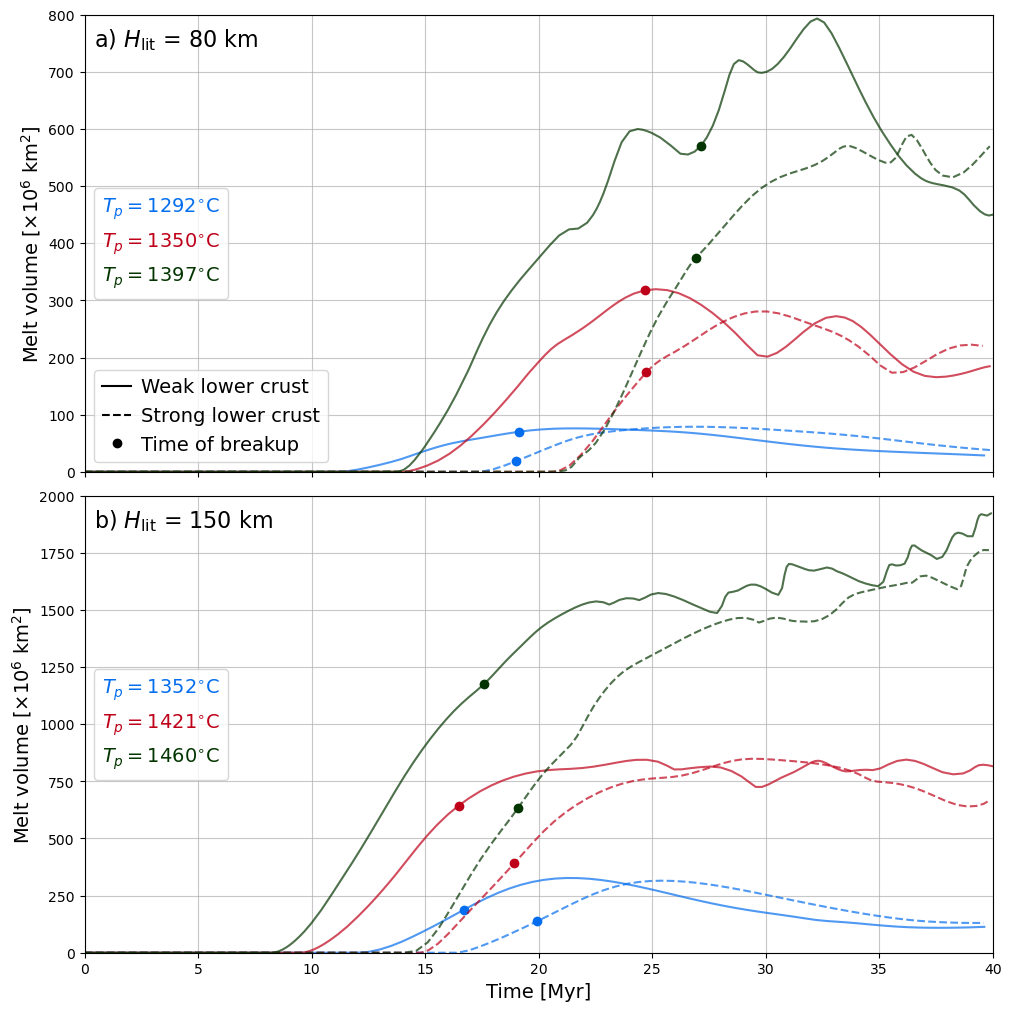

In [42]:
# Path to the model directory

groups =[#Hlit = 80 km
            ['/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK',

             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK',

             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK'

            #  '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc1_DT400_PT1437oC_lit80km_1x1km2_NHK',
            #  '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc10_DT400_PT1437oC_lit80km_1x1km2_NHK',
            ],
                #Hlit = 150 km
            ['/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK',

             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK',

             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK'
            ]
        ]

# local = True
local = False
if(local==True):
    partial_path = machine_path
else:
    external_media = 'Joao_Macedo'
    if(path[1] == 'home'):
        partial_path = f'/media/joao_macedo/{external_media}'
    elif(path[1] == 'Users'):
        partial_path = f'/Volumes/{external_media}'

#markers, lines and colors
colorsg =[['xkcd:cerulean blue',
          'xkcd:cerulean blue',
          'xkcd:scarlet',
          'xkcd:scarlet',
          'xkcd:dark green',
          'xkcd:dark green',
          #'xkcd:purple',
          #'xkcd:purple',
        ],
        ['xkcd:cerulean blue',
          'xkcd:cerulean blue',
          'xkcd:scarlet',
          'xkcd:scarlet',
          'xkcd:dark green',
          'xkcd:dark green',
        ],
        ]

linesg =[['-',
          '--',
          '-',
          '--',
          '-',
          '--',
        ],
        ['-',
         '--',
         '-',
         '--',
         '-',
         '--',
        ],
        ]

# tbs = [[19.11, 19.0, 24.66, 24.74, 27.14, 26.91,
#         # 30.74,
#         # 30.38
#         ],
#        [16.72, 19.91, 16.47, 18.93, 17.59, 19.08]
#       ]

#steps for time breakup - groups
tbsg = [[4100,
        3800,
        6500,
        6300,
        10200,
        10300,
        # 17700,
        # 17000
        ],
        [3400,
        4100,
        4000,
        4500,
        5000,
        5200]
]

melt_method = 'Dry'
# melt_method = 'Wet'

plt.close()
fig, axs = plt.subplots(2, 1, figsize=(10,10), constrained_layout=True, sharex=True)

for group, ax, colorg, lineg, tbs in zip(groups, axs, colorsg, linesg, tbsg):
    for scenario, color, line, tb in zip(group, colorg, lineg, tbs):
        # building model_path
        model_path = f'{partial_path}{scenario}'
        print(model_path.split('/')[-1])
        Vmelt_dataset = xr.open_dataset(f"{model_path}/_melt_volume_evolution_dataset.nc")
        steps = np.asarray(Vmelt_dataset.step)
        idx = np.where(steps == tb)
        if (melt_method == 'Dry'):
          ax.plot(Vmelt_dataset.time, Vmelt_dataset.vmelt_dry/1.0e6, line, alpha=0.7, color=color)
          ax.plot(Vmelt_dataset.time[idx], Vmelt_dataset.vmelt_dry[idx]/1.0e6, 'o', alpha=1.0, color=color)

        elif (melt_method == 'Wet'):
          ax.plot(Vmelt_dataset.time, Vmelt_dataset.vmelt_wet/1.0e6, line, alpha=0.7, color=color)
          ax.plot(Vmelt_dataset.time[idx], Vmelt_dataset.vmelt_wet[idx]/1.0e6, 'o', alpha=1.0, color=color)

###############################################################################################
axs[0].text(0.01, 0.93, r'a) $H_{\mathrm{lit}}$ = 80 km', color='black', fontsize=16, transform=axs[0].transAxes)
axs[1].text(0.01, 0.93, r'b) $H_{\mathrm{lit}}$ = 150 km', color='black', fontsize=16, transform=axs[1].transAxes)

ax1 = axs[0].twinx()
ax1.axis('off')
ax1.plot(-10, -10, '-', color = 'xkcd:black', label = 'Weak lower crust')
ax1.plot(-10, -10, '--', color = 'xkcd:black', label = 'Strong lower crust')
ax1.plot(-10, -10, 'o', color = 'xkcd:black', label = 'Time of breakup')
ax1.legend(loc='lower left', labelcolor='linecolor', handlelength=1.5, handletextpad=0.5, fontsize=14)

ax2 = axs[0].twinx()
ax2.axis('off')
ax2.plot(-10, -10, '-', color = 'xkcd:cerulean blue', label = r'$T_p = 1292 ^{\circ}$C')
ax2.plot(-10, -10, '-', color = 'xkcd:scarlet', label = r'$T_p = 1350 ^{\circ}$C')
ax2.plot(-10, -10, '-', color = 'xkcd:dark green', label = r'$T_p = 1397 ^{\circ}$C')
ax2.legend(loc='center left', labelcolor='linecolor', handlelength=0, handletextpad=0, fontsize=14)

ax3 = axs[1].twinx()
ax3.axis('off')
ax3.plot(-10, -10, '-', color = 'xkcd:cerulean blue', label = r'$T_p = 1352 ^{\circ}$C')
ax3.plot(-10, -10, '-', color = 'xkcd:scarlet', label = r'$T_p = 1421 ^{\circ}$C')
ax3.plot(-10, -10, '-', color = 'xkcd:dark green', label = r'$T_p = 1460 ^{\circ}$C')
ax3.legend(loc='center left', labelcolor='linecolor', handlelength=0, handletextpad=0, fontsize=14)

###################################################################################################
if (melt_method == 'Dry'):
  axs[0].set_ylim([0, 800])
  axs[1].set_ylim([0, 2000])
elif (melt_method == 'Wet'):
  axs[0].set_ylim([20000, 65000])
  axs[1].set_ylim([20000, 65000])

axs[0].set_xlim(0, Vmelt_dataset.time[-1])
axs[0].set_xticks(np.arange(0, Vmelt_dataset.time[-1]+5, 5))

axs[1].set_xlabel('Time [Myr]', fontsize=14)

axs[0].set_ylabel(r'Melt volume [$\times 10^6$ km$^2$]', fontsize=14)
axs[1].set_ylabel(r'Melt volume [$\times 10^6$ km$^2$]', fontsize=14)

axs[0].grid('-k', alpha=0.7)
axs[1].grid('-k', alpha=0.7)

figname = f"RTF_Melt_Volume_Evolution_{melt_method}_model"
fig.savefig(f"out/plots/{figname}.pdf", dpi=400)
fig.savefig(f"out/plots/{figname}.png", dpi=400)

In [8]:
len(Vmelt_dataset.time), len(Vmelt_dataset.vmelt_dry)

(132, 133)

# Plot Melt Volume rate for numerical scenarios

RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK
RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK
RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK
RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK
RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK
RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK
RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK
RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK
RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK
RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK
RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK
RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK


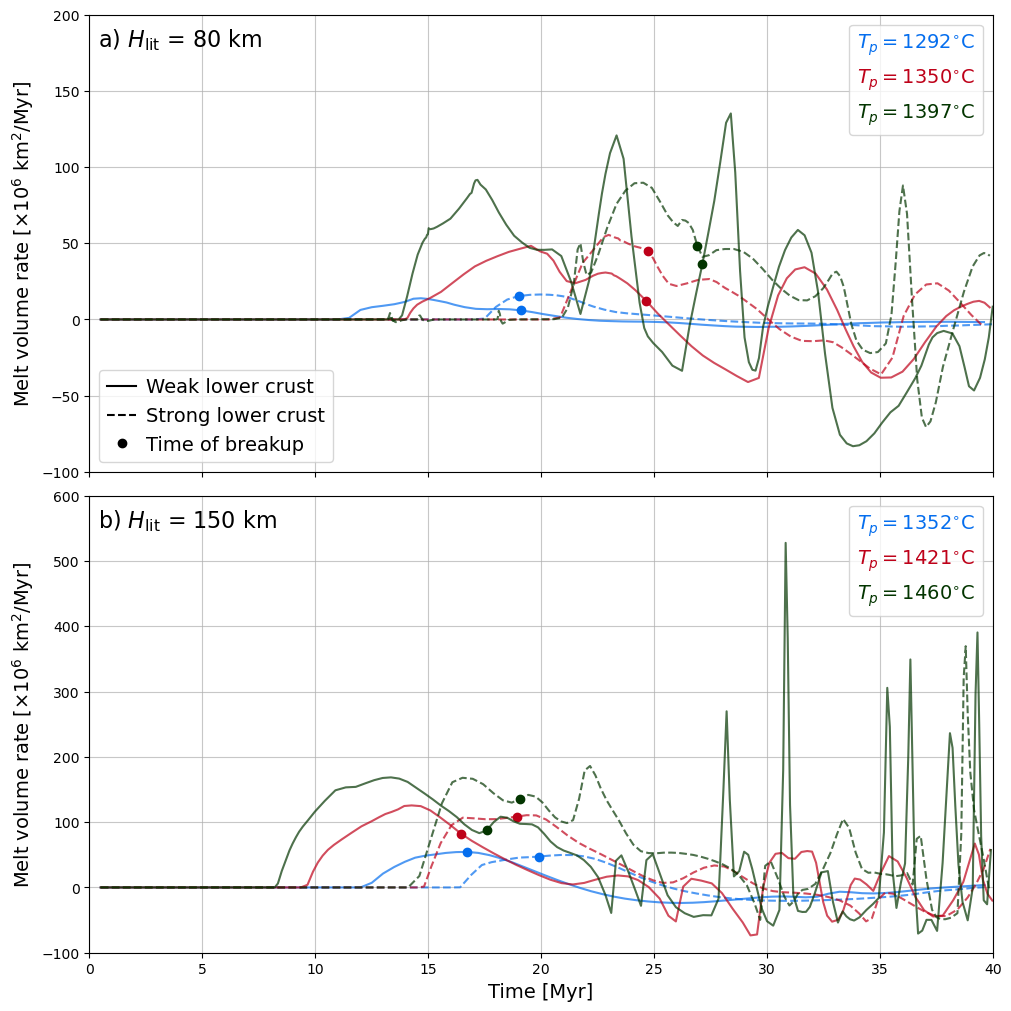

In [41]:
# Path to the model directory

groups =[#Hlit = 80 km
            ['/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK',

             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK',

             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK'

            #  '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc1_DT400_PT1437oC_lit80km_1x1km2_NHK',
            #  '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc10_DT400_PT1437oC_lit80km_1x1km2_NHK',
            ],
                #Hlit = 150 km
            ['/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK',

             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK',

             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK',
             '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK'
            ]
        ]

# local = True
local = False
if(local==True):
    partial_path = machine_path
else:
    external_media = 'Joao_Macedo'
    if(path[1] == 'home'):
        partial_path = f'/media/joao_macedo/{external_media}'
    elif(path[1] == 'Users'):
        partial_path = f'/Volumes/{external_media}'

#markers, lines and colors
colorsg =[['xkcd:cerulean blue',
          'xkcd:cerulean blue',
          'xkcd:scarlet',
          'xkcd:scarlet',
          'xkcd:dark green',
          'xkcd:dark green',
          #'xkcd:purple',
          #'xkcd:purple',
        ],
        ['xkcd:cerulean blue',
          'xkcd:cerulean blue',
          'xkcd:scarlet',
          'xkcd:scarlet',
          'xkcd:dark green',
          'xkcd:dark green',
        ],
        ]

linesg =[['-',
          '--',
          '-',
          '--',
          '-',
          '--',
        ],
        ['-',
         '--',
         '-',
         '--',
         '-',
         '--',
        ],
        ]

# tbs = [[19.11, 19.0, 24.66, 24.74, 27.14, 26.91,
#         # 30.74,
#         # 30.38
#         ],
#        [16.72, 19.91, 16.47, 18.93, 17.59, 19.08]
#       ]

#steps for time breakup - groups
tbsg = [[4100,
        3800,
        6500,
        6300,
        10200,
        10300,
        # 17700,
        # 17000
        ],
        [3400,
        4100,
        4000,
        4500,
        5000,
        5200]
]

melt_method = 'Dry'
# melt_method = 'Wet'

plt.close()
fig, axs = plt.subplots(2, 1, figsize=(10,10), constrained_layout=True, sharex=True)

for group, ax, colorg, lineg, tbs in zip(groups, axs, colorsg, linesg, tbsg):
    for scenario, color, line, tb in zip(group, colorg, lineg, tbs):
        # building model_path
        model_path = f'{partial_path}{scenario}'
        print(model_path.split('/')[-1])
        Vmelt_dataset = xr.open_dataset(f"{model_path}/_melt_volume_evolution_dataset.nc")
        steps = np.asarray(Vmelt_dataset.step)
        idx = np.where(steps == tb)[0][0]

        if (melt_method == 'Dry'):
          Vmelt_rate = np.asarray(np.diff(Vmelt_dataset.vmelt_dry)/np.diff(Vmelt_dataset.time))
          ax.plot(Vmelt_dataset.time[1:], Vmelt_rate/1.0e6, line, alpha=0.7, color=color)
          ax.plot(Vmelt_dataset.time[idx], Vmelt_rate[idx-1]/1.0e6, 'o', alpha=1.0, color=color)

        elif (melt_method == 'Wet'):
          Vmelt_rate = np.asarray(np.diff(Vmelt_dataset.vmelt_wet)/np.diff(Vmelt_dataset.time))
          ax.plot(Vmelt_dataset.time[1:], Vmelt_rate/1.0e6, line, alpha=0.7, color=color)
          ax.plot(Vmelt_dataset.time[idx], Vmelt_rate[idx-1]/1.0e6, 'o', alpha=1.0, color=color)

###############################################################################################
axs[0].text(0.01, 0.93, r'a) $H_{\mathrm{lit}}$ = 80 km', color='black', fontsize=16, transform=axs[0].transAxes)
axs[1].text(0.01, 0.93, r'b) $H_{\mathrm{lit}}$ = 150 km', color='black', fontsize=16, transform=axs[1].transAxes)

ax1 = axs[0].twinx()
ax1.axis('off')
ax1.plot(-10, -10, '-', color = 'xkcd:black', label = 'Weak lower crust')
ax1.plot(-10, -10, '--', color = 'xkcd:black', label = 'Strong lower crust')
ax1.plot(-10, -10, 'o', color = 'xkcd:black', label = 'Time of breakup')
ax1.legend(loc='lower left', labelcolor='linecolor', handlelength=1.5, handletextpad=0.5, fontsize=14)

ax2 = axs[0].twinx()
ax2.axis('off')
ax2.plot(-10, -10, '-', color = 'xkcd:cerulean blue', label = r'$T_p = 1292 ^{\circ}$C')
ax2.plot(-10, -10, '-', color = 'xkcd:scarlet', label = r'$T_p = 1350 ^{\circ}$C')
ax2.plot(-10, -10, '-', color = 'xkcd:dark green', label = r'$T_p = 1397 ^{\circ}$C')
ax2.legend(loc='upper right', labelcolor='linecolor', handlelength=0, handletextpad=0, fontsize=14)

ax3 = axs[1].twinx()
ax3.axis('off')
ax3.plot(-10, -10, '-', color = 'xkcd:cerulean blue', label = r'$T_p = 1352 ^{\circ}$C')
ax3.plot(-10, -10, '-', color = 'xkcd:scarlet', label = r'$T_p = 1421 ^{\circ}$C')
ax3.plot(-10, -10, '-', color = 'xkcd:dark green', label = r'$T_p = 1460 ^{\circ}$C')
ax3.legend(loc='upper right', labelcolor='linecolor', handlelength=0, handletextpad=0, fontsize=14)

###################################################################################################
if (melt_method == 'Dry'):
  axs[0].set_ylim([-100, 200])
  axs[1].set_ylim([-100, 600])
elif (melt_method == 'Wet'):
  axs[0].set_ylim([-150, 550])
  axs[1].set_ylim([100, 600])

axs[0].set_xlim(0, Vmelt_dataset.time[-1])
axs[0].set_xticks(np.arange(0, Vmelt_dataset.time[-1]+5, 5))

axs[1].set_xlabel('Time [Myr]', fontsize=14)

axs[0].set_ylabel(r'Melt volume rate [$\times 10^6$ km$^2$/Myr]', fontsize=14)
axs[1].set_ylabel(r'Melt volume rate [$\times 10^6$ km$^2$/Myr]', fontsize=14)

axs[0].grid('-k', alpha=0.7)
axs[1].grid('-k', alpha=0.7)

figname = f"RTF_Melt_Volume_Rate_{melt_method}_model"
fig.savefig(f"out/plots/{figname}.pdf", dpi=400)
fig.savefig(f"out/plots/{figname}.png", dpi=400)

In [39]:
idx[0][0]

52

In [21]:
t = np.array([0, 1, 2, 3, 4, 5, 6])
b = np.array([0, 15, 35, 35, 45, 55, 95])

br = b[1::] - b[0:-1:]
br

array([15, 20,  0, 10, 10, 40])

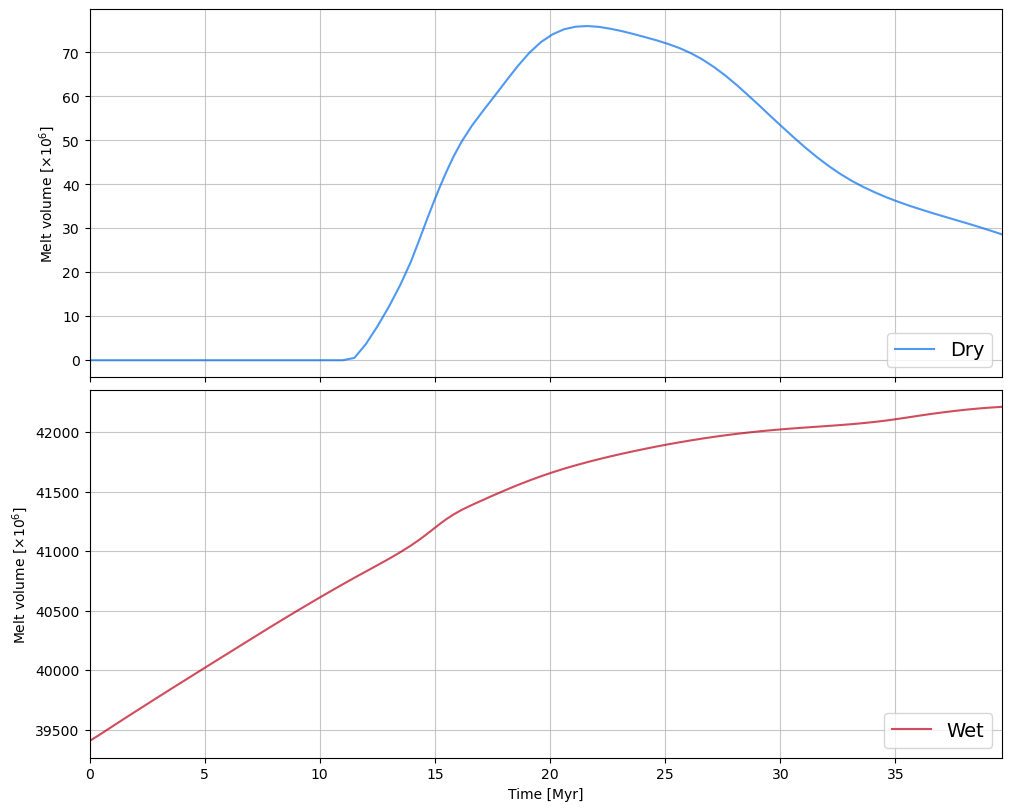

In [62]:
plt.close()
fig, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True, sharex=True)

axs[0].plot(Vmelt_dataset.time, Vmelt_dataset.vmelt_dry/1.0e6, alpha=0.7, label = 'Dry', color='xkcd:cerulean blue')
axs[1].plot(Vmelt_dataset.time, Vmelt_dataset.vmelt_wet/1.0e6, alpha=0.7, label='Wet', color='xkcd:scarlet')

axs[0].set_xlim(0, Vmelt_dataset.time[-1])
# ax.set_ylim([0, 100])
axs[1].set_xlabel('Time [Myr]')

axs[0].set_ylabel(r'Melt volume [$\times 10^6$]')
axs[1].set_ylabel(r'Melt volume [$\times 10^6$]')
axs[0].grid('-k', alpha=0.7)
axs[1].grid('-k', alpha=0.7)
axs[0].legend(loc='lower right', fontsize=14)
axs[1].legend(loc='lower right', fontsize=14)

figname = f"{scenario.split('/')[-1]}_MeltVolume_evolution"
fig.savefig(f"{model_path}/{figname}.pdf", dpi=400)
fig.savefig(f"{model_path}/{figname}.png", dpi=400)